# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import cv2 as cv

In [2]:
directory = "Data/GenderImages"
train_dir = os.path.join(directory,"Training")
val_dir = os.path.join(directory, "Validation")

## Merging UTKFace Dataset with Gender Dataset

In [3]:
'''
rows = []
for filename in os.listdir(os.path.join('Data','UTKface')):
    values = filename.split('_')
    # some files do not have all attributes
    if len(values) == 4:
        values[-1] = filename
        values = values[::-1]
        rows.append(values)

df_gender = pd.DataFrame(rows,columns=['filename','race','gender','age'])
df_gender = df_gender.astype({'race':int,'gender':int,'age':int})

df_male = df_gender[df_gender['gender'] == 0]
df_male_train=df_male.sample(frac=0.9,random_state=1)
df_male_test=df_male.drop(df_male_train.index).sample(frac=1.0)


df_female = df_gender[df_gender['gender'] == 1] # make df of males
df_female_train=df_female.sample(frac=0.9,random_state=1)
df_female_test=df_female.drop(df_female_train.index).sample(frac=1.0)
df_male.head()
'''
# writing the files from one directory to another, this takes a while to run (only run once)
'''
for file in df_male_train['filename'].values:
    try:
        shutil.copy(os.path.join('UTKFace',file), os.path.join(train_dir,'male'))
    except:
        print("Error for male train.")
        
for file in df_male_test['filename'].values:
    try:
        shutil.copy(os.path.join('UTKFace',file), os.path.join(val_dir,'male'))
    except:
        print("Error for male test.")
        
for file in df_female_train['filename'].values:
    try:
        shutil.copy(os.path.join('UTKFace',file), os.path.join(train_dir,'female'))
    except:
        print("Error for female train.")
        
for file in df_female_test['filename'].values:
    try:
        shutil.copy(os.path.join('UTKFace',file), os.path.join(val_dir,'female'))
    except:
        print("Error for female test.")
'''
print()

## Generators that Read Image Data and Perform Augmentations

In [64]:
# Create the image data generators
train_image_generator = ImageDataGenerator(rescale=(1.0/255),
                                           brightness_range=((0.6,1.1)),
                                           horizontal_flip=True
                                          )
validation_image_generator = ImageDataGenerator(rescale=(1.0/255))

train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    target_size=(128,128),
    color_mode="rgb",
    batch_size=64,
    class_mode="binary")

validation_data_gen = validation_image_generator.flow_from_directory(
    directory=val_dir,
    target_size=(128,128),
    color_mode="rgb",
    batch_size=64,
    class_mode="binary") 

Found 68343 images belonging to 2 classes.
Found 14019 images belonging to 2 classes.


## Visualizing the Data

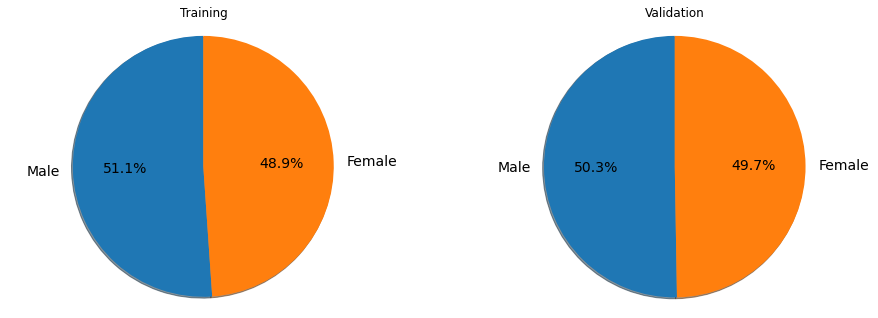

In [65]:
# Get the number of files in each directory
num_male_val = len(os.listdir(os.path.join(val_dir,'male')))
num_female_val = len(os.listdir(os.path.join(val_dir,'female')))

num_male_train = len(os.listdir(os.path.join(train_dir,'male')))
num_female_train = len(os.listdir(os.path.join(train_dir,'female')))

# training distribution and validation distribution
labels = ['Male','Female']
validation_values = [num_male_val,num_female_val]
train_values = [num_male_train,num_female_train]

fig, axs = plt.subplots(1,2,figsize=(12,4))
fig.subplots_adjust(0,0,1,1)

axs[0].pie(train_values, labels=labels, labeldistance=1.1, autopct='%1.1f%%',
           textprops={'fontsize': 14},radius=2,startangle=90,shadow=True)
axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[0].title.set_text('Training')

axs[1].pie(validation_values, labels=labels, labeldistance=1.1, autopct='%1.1f%%',
           textprops={'fontsize': 14},radius=2,startangle=90,shadow=True)
axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[1].title.set_text('Validation')

plt.show()

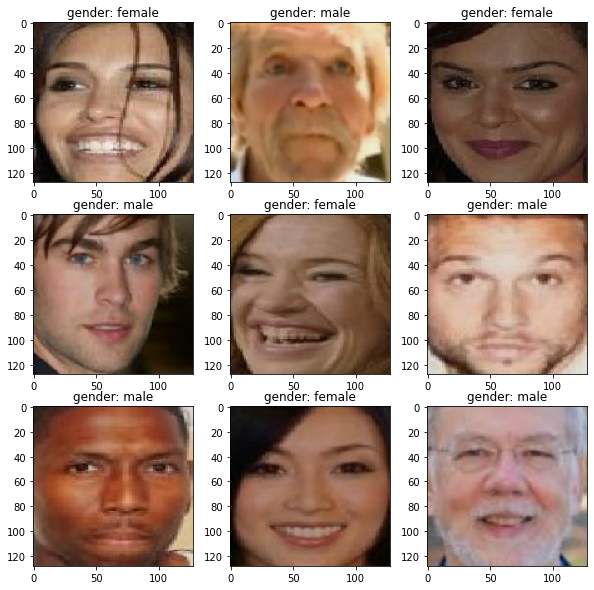

In [66]:
imgs, labels = next(train_data_gen)
plt.figure(figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(imgs[i])
    label = int(labels[i])
    if label == 0:
        label = 'female'
    else:
        label = 'male'
    plt.title('gender: ' + label)

# Creating the Model

In [67]:
# create the model
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 63, 63, 16)        64        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 30, 16)        64        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)       

## Training the Model

In [68]:
history = model.fit(x=train_data_gen,
                    epochs=10,
                    steps_per_epoch=None,
                    validation_data=validation_data_gen,
                    validation_steps=None)

Epoch 1/10
1068/1068 [==============================] - 580s 543ms/step - loss: 0.2602 - accuracy: 0.8960 - val_loss: 0.1571 - val_accuracy: 0.9425
Epoch 2/10
1068/1068 [==============================] - 269s 252ms/step - loss: 0.1759 - accuracy: 0.9312 - val_loss: 0.2155 - val_accuracy: 0.9124
Epoch 3/10
1068/1068 [==============================] - 274s 257ms/step - loss: 0.1533 - accuracy: 0.9402 - val_loss: 0.1345 - val_accuracy: 0.9499
Epoch 4/10
1068/1068 [==============================] - 270s 253ms/step - loss: 0.1416 - accuracy: 0.9451 - val_loss: 0.1284 - val_accuracy: 0.9504
Epoch 5/10
1068/1068 [==============================] - 289s 271ms/step - loss: 0.1297 - accuracy: 0.9498 - val_loss: 0.1406 - val_accuracy: 0.9453
Epoch 6/10
1068/1068 [==============================] - 273s 256ms/step - loss: 0.1220 - accuracy: 0.9536 - val_loss: 0.1252 - val_accuracy: 0.9531
Epoch 7/10
1068/1068 [==============================] - 421s 394ms/step - loss: 0.1133 - accuracy: 0.9571 - val_

## Visualizing the Predictions

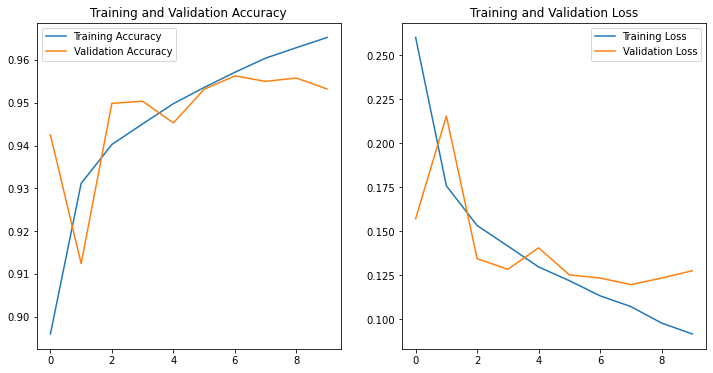

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, axs = plt.subplots(1,2,figsize=(12,6))

x = range(10)
axs[0].plot(x, acc, label='Training Accuracy')
axs[0].plot(x, val_acc, label='Validation Accuracy')
axs[0].title.set_text('Training and Validation Accuracy')
axs[0].legend(loc='upper left')

axs[1].plot(x, loss, label='Training Loss')
axs[1].plot(x, val_loss, label='Validation Loss')
axs[1].title.set_text('Training and Validation Loss')
axs[1].legend(loc='upper right')

plt.show()

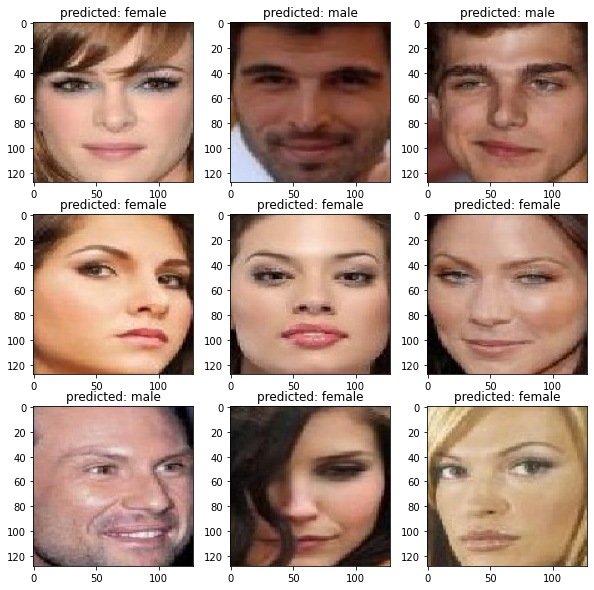

In [77]:
imgs, labels = next(validation_data_gen)
results = model.predict(imgs)
plt.figure(figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(imgs[i])
    gender = 'male'
    if results[i,0] < 0.5:
        gender = 'female'
        
    plt.title('predicted: ' + gender)

## Testing the Model on Custom Images

0.003362


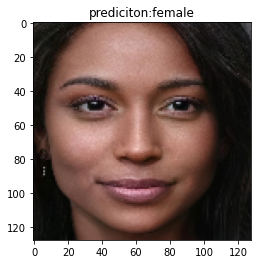

In [82]:
def predict_custom_gender(path):
    my_img = cv.imread(my_img_path)
    my_img = cv.resize(my_img,(128,128))
    my_img = cv.cvtColor(my_img, cv.COLOR_BGR2RGB)
    my_img = my_img/255.0
    my_predict = model.predict(np.array([my_img]))
    plt.imshow(my_img)
    gender = 'male'
    print(my_predict[0,0])
    if my_predict[0,0] < 0.5:
        gender = 'female'
    plt.title('prediciton:' + gender)
my_img_path = os.path.join('Data','CustomTest','1.jpg')
predict_custom_gender(my_img_path)

## Saving the Model (SavedModel format)

In [126]:
# save the model
model.save(os.path.join('Models','gender_model_95.47%'))

INFO:tensorflow:Assets written to: Models\gender_model_95.47%\assets


In [4]:
# load the model
loaded_model = tf.keras.models.load_model('Models/gender_model_95.47%')
loaded_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 63, 63, 16)        64        
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 30, 30, 16)        64        
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 32)       

## Saving the Model as TFLite for Mobile Application use

In [8]:
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

with open('gender_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\prath\AppData\Local\Temp\tmp70en4cn0\assets
